# Загрузка модулей и библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from tabulate import tabulate


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import AdditiveAttention, Concatenate
from tensorflow.keras.layers import TimeDistributed, Bidirectional, AdditiveAttention, Reshape
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Dropout, AdditiveAttention, GRU, RepeatVector, BatchNormalization

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop


from tensorflow.python.framework.errors_impl import NotFoundError  # Импортируем исключение

from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import Hyperband

import os
import shutil
import json
import time

# Формируем базовый датасет df_calc_sec_2

In [5]:
# Загрузка данных

# Путь к файлу данных .parquet
path = r"C:\Learn_project\Intern_1\data\df_calc_sec_2.parquet"

# Читаем данные из Parquet-файла
df = pd.read_parquet(path)

# Выведем первые строки таблицы для проверки
print(df.head())

          source_time  mode    value_14  value_10   value_16  value_10_lag_1  \
0 2024-04-07 03:21:30     1  156.200000  2.911765  38.863636        0.000000   
1 2024-04-07 03:22:00     1  155.714286  2.941176  38.855519        2.911765   
2 2024-04-07 03:22:30     1  155.000000  2.911765  38.863636        2.941176   
3 2024-04-07 03:23:00     1  154.000000  2.911765  38.863636        2.911765   
4 2024-04-07 03:23:30     1  154.000000  2.911765  38.863636        2.911765   

   value_10_lag_2  value_10_lag_3  value_10_lag_4  value_10_lag_5  ...  \
0        0.000000        0.000000        0.000000             0.0  ...   
1        0.000000        0.000000        0.000000             0.0  ...   
2        2.911765        0.000000        0.000000             0.0  ...   
3        2.941176        2.911765        0.000000             0.0  ...   
4        2.911765        2.941176        2.911765             0.0  ...   

   value_16_lag_6  value_16_diff_1  value_16_rolling_mean_3  \
0          

In [6]:
# Удаляем столбец 'mode' и назначаем целевую переменную 'value_14'
df = df.drop(columns=['mode'])

# Функции и подготовка исходных данных

Функции нормализации и денормализации данных

In [7]:
# Глобальная переменная скейлера для нормализации и денормализации
scaler = MinMaxScaler(feature_range=(0, 1))

# Функция нормализации данных
def normalize_data(values):
    """Преобразует данные в диапазон [0, 1]"""
    global scaler
    scaled_values = scaler.fit_transform(values.reshape(-1, 1))
    return scaled_values.flatten()

# Функция денормализации данных
def denormalize_data(scaled_values):
    """Восстанавливает оригинальные значения из нормализованных"""
    global scaler
    original_values = scaler.inverse_transform(scaled_values.reshape(-1, 1))
    return original_values.flatten()

Функция формирования выборки

In [8]:
# Функция подготовки данных
def prepare_data(arr, look_back=10, n_output_steps=120):
    """
    Функция подготовки данных для временного ряда.
    :param arr: Массив временных данных
    :param look_back: Сколько шагов назад смотрит модель
    :param n_output_steps: Сколько шагов вперед прогнозировать
    :return: Входные (X) и выходные (Y) данные
    """
    X, Y = [], []
    for i in range(len(arr)-look_back-n_output_steps+1):
        seq_in = arr[i:i+look_back]
        seq_out = arr[i+look_back:i+look_back+n_output_steps]
        X.append(seq_in)
        Y.append(seq_out)
    X_array = np.array(X)
    Y_array = np.array(Y)
    print("Формы после подготовки данных:")
    print("X:", X_array.shape)
    print("Y:", Y_array.shape)
    return X_array, Y_array

Арихтектура модели

In [9]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

Подготовка данных

In [10]:
# Ограничиваем диапазон дат
start_date = '2024-06-01'
end_date = '2024-09-01'

# Ограничиваем датасет периодом обучения
df = df[(df['source_time'] >= start_date) & (df['source_time'] <= end_date)]

# Удаляем столбец 'mode' и назначаем целевую переменную 'value_14'
#df = df.drop(columns=['mode'])


# Основные настройки
look_back = 10            # Сколько шагов назад смотрим
n_features = 1            # Всего один признак (одно измерение временного ряда)
#lags = [20, 30, 40, 60, 90, 120]  # Лаги для экспериментов
lags = [20]               # 10 мин.
step = 2                  # масштаб для расчета времени лага

# Определяем целевую переменную
values = df["value_14"].values

# Нормализация данных
scaled_values = normalize_data(values)

Подготовка данных для тестирования

In [11]:
# Загрузка предварительно обработанного DataFrame
df_test = pd.read_parquet(path)

# Удаляем ненужный столбец 'mode' и выбираем целевой признак 'value_14'
df_test = df_test.drop(columns=['mode'])

# Устанавливаем диапазон дат
start_date = '2024-10-01'
end_date = '2024-12-01'

# Фильтруем датасет по указанному периоду
df_test = df_test[(df_test['source_time'] >= start_date) & (df_test['source_time'] <= end_date)]

# Оставляем только числовую колонку value_14 для масштабирования
values_to_scale = df_test['value_14'].values.reshape(-1, 1)

# Преобразуем и масштабируем тестовые данные
test_scaled_values = scaler.transform(df_test['value_14'].values.reshape(-1, 1)).ravel()

# Функция подготовки тестовых данных
def prepare_test_data(values, look_back, lag):
    dataX, dataY = [], []
    for i in range(len(values)-look_back-lag+1):
        a = values[i:(i + look_back)]
        b = values[(i + look_back):(i + look_back + lag)]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

Функция оценки модели на проверочной выборке

In [12]:
def evaluate_validation_set(model, X_val, Y_val, lag, denormalize_data):

    # Прогнозируем на проверочной выборке
    predicted_values = model.predict(X_val)

    # Развёртываем и денормализуем данные
    y_true_denorm = denormalize_data(Y_val.flatten())
    y_pred_denorm = denormalize_data(predicted_values.flatten())

    # Добавляем небольшую константу, чтобы избежать деления на ноль
    epsilon = 1e-8
    y_true_adjusted = np.where(y_true_denorm != 0, y_true_denorm, epsilon)

    # Рассчитываем среднюю относительную ошибку (RMAE)
    relative_errors = np.abs((y_true_adjusted - y_pred_denorm)) / y_true_adjusted
    mean_relative_error = relative_errors.mean()

    # Медиана относительной ошибки (Median Relative Error)
    median_re = np.median(relative_errors)

    # Расчёт MAE
    mae_score = mean_absolute_error(y_true_denorm, y_pred_denorm)

    # Медианная абсолютная ошибка (Median Absolute Error)
    median_ae = median_absolute_error(y_true_denorm, y_pred_denorm)

    # Печать результатов
    print('\nОценка точности на проверочной выборке:')
    print("\nФорма итоговой оценки:")
    print("Форма значений проверочной выборки Y_val:", Y_val.flatten().shape)
    print("Форма предсказанных значений:", predicted_values.flatten().shape)
    print(f'\nСреднее абсолютное отклонение (MAE) для лагов {lag} на проверочной выборке: {mae_score:.4f}')
    print(f"Медиана абсолютного отклонения (Median AE) для лагов {lag} на проверочной выборке: {median_ae:.4f}")
    print(f'Средняя относительная ошибка (RMAE) для лагов {lag} на проверочной выборке: {mean_relative_error:.4%}\n')
    print(f"Медиана относительной ошибки (Median RE) для лагов {lag} на проверочной выборке:: {median_re:.4%}\n")

# Вызов функции
# evaluate_validation_set(model, X_val, Y_val, lag, denormalize_data)

Функция оценки модели на тестовых данных

In [13]:
def evaluate_test_set(model, test_scaled_values, look_back, lag, denormalize_data):

    # Подготовливаем тестовый набор
    test_X, test_Y = prepare_test_data(test_scaled_values, look_back, lag)

    # Приводим test_X к нужной форме
    test_X = test_X.reshape(-1, look_back, 1)

    # Формируем отчёт о форме данных
    print("\nФорма тестового набора данных:")
    print("test_X:", test_X.shape)
    print("test_Y:", test_Y.shape)

    # Прогнозируем на тестовом наборе
    test_predictions = model.predict(test_X)

    # Обратное преобразование к оригиналу
    Y_test_true_denorm = denormalize_data(test_Y.flatten())
    Y_test_pred_denorm = denormalize_data(test_predictions.flatten())

    # Медианная абсолютная ошибка (Median Absolute Error)
    test_median_ae = median_absolute_error(Y_test_true_denorm, Y_test_pred_denorm)

    # Рассчитываем среднюю абсолютную ошибку (MAE)
    test_mae_score = mean_absolute_error(Y_test_true_denorm, Y_test_pred_denorm)

    # Оцениваем относительную ошибку (RMAE)
    epsilon = 1e-8
    test_y_true_adjusted = np.where(Y_test_true_denorm != 0, Y_test_true_denorm, epsilon)
    test_relative_errors = np.abs((test_y_true_adjusted - Y_test_pred_denorm)) / test_y_true_adjusted
    test_mean_relative_error = test_relative_errors.mean()

    # Медиана относительной ошибки (Median Relative Error)
    test_median_re = np.median(test_relative_errors)

    # Печать результатов
    print("\nФорма после предсказаний на тестовом наборе")
    print("Предсказание на тестовых данных:", test_predictions.shape)

    # Результаты оценки на тестовом наборе
    print("\nФормы итоговой оценки на тестовом наборе данных:")
    print("Тестовые данные:", test_Y.flatten().shape)
    print("Предсказанные данные:", test_predictions.flatten().shape)
    print(f"\nСреднее абсолютное отклонение (MAE) для лагов {lag} на тестовом наборе: {test_mae_score:.4f}")
    print(f"Медиана абсолютного отклонения (Median AE) для лагов {lag} на тестовом наборе: {test_median_ae:.4f}")
    print(f"Средняя относительная ошибка (RMAE) для лагов {lag} на тестовом наборе: {test_mean_relative_error:.4%}\n")
    print(f"Медиана относительной ошибки (Median RE) для лагов {lag} на тестовом наборе: {test_median_re:.4%}\n")


# Вызов функции
# evaluate_test_set(model, test_scaled_values, look_back, lag, denormalize_data)

Функция сохранения промежуточных результатов автоподбора параметров

In [14]:
# Настройки для чекпоинтов и временных папок
CHECKPOINT_DIR = './checkpoints/'
TUNING_RESULTS_FILE = 'tuning_results.json'
MODEL_CHECKPOINT_PATH = CHECKPOINT_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'



# Загружаем предыдущие результаты (или инициализируем пустые, если нет)
def load_tuning_state():
    try:
        with open(TUNING_RESULTS_FILE, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        return {"current_lag": 0}

# Сохраняем текущее состояние настройки гиперпараметров
def save_tuning_state(data):
    with open(TUNING_RESULTS_FILE, 'w') as file:
        json.dump(data, file, indent=4)

# Функция загрузки предыдущей конфигурации
previous_state = load_tuning_state()
current_lag_idx = previous_state["current_lag"]

# Модель №2_авто

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import Hyperband
from kerastuner.engine.hypermodel import HyperModel
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
from datetime import datetime
import numpy as np
import os
import time
import json


# Custom Callback для вставки паузы после каждой эпохи
class EpochPauseCallback(tf.keras.callbacks.Callback):
    def __init__(self, pause_time=5):
        super(EpochPauseCallback, self).__init__()
        self.pause_time = pause_time  # Длительность паузы в секундах

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n🚨 Эпоха {epoch + 1} завершена. 🛌 Пауза на {self.pause_time} секунд.\n")
        time.sleep(self.pause_time)
        print(f"✅ Пауза закончилась. Продолжаем обучение!\n")


# Функция для сохранения состояния тюнера
def save_tuner_state(tuner, file_path):
    """Сохраняет текущее состояние тюнера."""
    state = {
        'trials': len(tuner.oracle.trials),
        'best_trial_id': tuner.oracle.get_best_trials()[0].trial_id
    }
    with open(file_path, 'w') as file:
        json.dump(state, file)


# Функция для загрузки сохранённого состояния
def load_tuner_state(file_path):
    """Загружает сохранённое состояние тюнера."""
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        return None


# Новая архитектура модели
def create_attention_model(hp, look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Настраиваемые гиперпараметры
    filters_1 = hp.Int('filters_1', min_value=32, max_value=512, step=24)
    kernel_size_1 = hp.Choice('kernel_size_1', values=[3, 5, 7])
    bi_lstm_units = hp.Int('bi_lstm_units', min_value=64, max_value=512, step=24)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dense_units_1 = hp.Int('dense_units_1', min_value=64, max_value=1024, step=24)
    dense_units_2 = hp.Int('dense_units_2', min_value=64, max_value=512, step=24)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Архитектура модели
    conv = Conv1D(filters=filters_1, kernel_size=kernel_size_1, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)
    lstm = Bidirectional(LSTM(bi_lstm_units, return_sequences=True))(pool)
    drop = Dropout(dropout_rate)(lstm)
    attention = AdditiveAttention()([drop, drop])
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])
    dense_layer_1 = Dense(dense_units_1, activation="relu", kernel_regularizer=l2(0.01))(Flatten()(spatially_enriched_context))
    dense_layer_2 = Dense(dense_units_2, activation="relu", kernel_regularizer=l2(0.01))(dense_layer_1)
    combined = Concatenate(axis=-1)([Flatten()(attention), dense_layer_2])
    output = Dense(n_output_steps)(combined)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])
    return model


# Класс HyperModel для Keras Tuner
class AttentionHyperModel(HyperModel):
    def __init__(self, look_back, n_features, n_output_steps):
        self.look_back = look_back
        self.n_features = n_features
        self.n_output_steps = n_output_steps

    def build(self, hp):
        return create_attention_model(hp, self.look_back, self.n_features, self.n_output_steps)




# Процедура экспериментов с подбором гиперпараметров
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} ({lag // step} минут) =====")

    # Генерируем входные данные
    X, Y = prepare_data(scaled_values, look_back, lag)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Если один признак

    # Разделяем данные на тренировочную и валидационную части
    split_point = int(len(X) * 0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Настроим пространство гиперпараметров
    hypermodel = AttentionHyperModel(look_back, 1, Y_train.shape[1])  # Один признак (можно поменять)

    # Директория для хранения результатов
    results_dir = 'search_results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    state_file = f'{results_dir}/tuner_state_lag_{lag}.json'

    # Загрузка предыдущего состояния, если оно существует
    previous_state = load_tuner_state(state_file)

    # Создаем объект Hyperband для поиска гиперпараметров
    tuner = Hyperband(
        hypermodel,
        objective='val_mae',
        max_epochs=50,
        factor=4,
        directory=f'tuning_{lag}_NEW',
        project_name=f'attention_model_lag_{lag}',
        overwrite=False  # Продолжаем предыдущий поиск
    )

    # Продолжаем поиск параметров с последнего запуска
    if previous_state is not None:
        print(f"Продолжаем поиск параметров с предыдущей сессии.")
        tuner.reload()  # Восстанавливаем состояние
    else:
        print(f"Создаем новый поиск параметров.")

    # Запускаем процесс поиска лучших гиперпараметров
    tuner.search(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            EpochPauseCallback(pause_time=10)  # Пауза между эпохами
        ]
    )

    # Сохраняем текущее состояние тюнера
    save_tuner_state(tuner, state_file)

    # Получаем лучшие гиперпараметры
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nЛучшие гиперпараметры:")
    for key, value in best_hp.values.items():
        print(f"{key}: {value}")

    # Строим финальную модель с наилучшими параметрами
    final_model = hypermodel.build(best_hp)

    # Переподбираем финальную модель
    final_history = final_model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            EpochPauseCallback(pause_time=10)  # Пауза между эпохами
        ],
        verbose=1
    )

    # Оцениваем качество модели на валидации
    evaluate_validation_set(final_model, X_val, Y_val, lag, denormalize_data)

    # Готовимся к оценке на тестовых данных
    test_X, _ = prepare_test_data(test_scaled_values, look_back, lag)
    test_X = test_X.reshape((-1, look_back, 1))

    # Прогнозируем и оцениваем на тестовых данных
    predictions = final_model.predict(test_X)
    test_predictions_denorm = denormalize_data(predictions)
    evaluate_test_set(final_model, test_scaled_values, look_back, lag, denormalize_data)

    # Сохраняем финальную модель
    final_model.save(f'final_model_lag_{lag}.h5')

Trial 44 Complete [01h 51m 45s]
val_mae: 0.05239036679267883

Best val_mae So Far: 0.05239036679267883
Total elapsed time: 6d 05h 23m 27s

Лучшие гиперпараметры:
filters_1: 512
kernel_size_1: 5
bi_lstm_units: 184
dropout_rate: 0.1
dense_units_1: 352
dense_units_2: 208
learning_rate: 0.00016825922773820587
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 1.1006 - mae: 0.0757
🚨 Эпоха 1 завершена. 🛌 Пауза на 10 секунд.

✅ Пауза закончилась. Продолжаем обучение!

3312/3312 ━━━━━━━━━━━━━━━━━━━━ 421s 126ms/step - loss: 1.1003 - mae: 0.0757 - val_loss: 0.0108 - val_mae: 0.0582
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0108 - mae: 0.0570
🚨 Эпоха 2 завершена. 🛌 Пауза на 10 секунд.

✅ Пауза закончилась. Продолжаем обучение!

3312/3312 ━━━━━━━━━━━━━━━━━━━━ 427s 129ms/step - loss: 0.0108 - mae: 0.0570 - val_loss: 0.0108 - val_mae: 0.0605
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/s

Медиана относительной ошибки (Median RE) для лагов 20 на тестовом наборе: 13.9584%



# Обучение на полном ряде лаговых сдвигов вперёд
- дообучение на лаговом сдвиге 120

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving df_calc_sec_2.parquet to df_calc_sec_2.parquet


In [ ]:
# Подгружвем df_14 если было автоматическое прерываение работы колаба
df = pd.read_parquet('/content/df_calc_sec_2.parquet')

# Удаляем столбец 'mode' и назначаем целевую переменную 'value_14'
df = df.drop(columns=['mode'])

In [ ]:
# Глобальная переменная скейлера для нормализации и денормализации
scaler = MinMaxScaler(feature_range=(0, 1))

# Функция нормализации данных
def normalize_data(values):
    """Преобразует данные в диапазон [0, 1]"""
    global scaler
    scaled_values = scaler.fit_transform(values.reshape(-1, 1))
    return scaled_values.flatten()

# Функция денормализации данных
def denormalize_data(scaled_values):
    """Восстанавливает оригинальные значения из нормализованных"""
    global scaler
    original_values = scaler.inverse_transform(scaled_values.reshape(-1, 1))
    return original_values.flatten()

In [ ]:
# Функция подготовки данных
def prepare_data(arr, look_back=10, n_output_steps=120):
    """
    Функция подготовки данных для временного ряда.
    :param arr: Массив временных данных
    :param look_back: Сколько шагов назад смотрит модель
    :param n_output_steps: Сколько шагов вперед прогнозировать
    :return: Входные (X) и выходные (Y) данные
    """
    X, Y = [], []
    for i in range(len(arr)-look_back-n_output_steps+1):
        seq_in = arr[i:i+look_back]
        seq_out = arr[i+look_back:i+look_back+n_output_steps]
        X.append(seq_in)
        Y.append(seq_out)
    X_array = np.array(X)
    Y_array = np.array(Y)
    print("Shapes after preparation:")
    print("X:", X_array.shape)
    print("Y:", Y_array.shape)
    return X_array, Y_array

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [ ]:
# Ограничиваем диапазон дат
start_date = '2024-06-01'
end_date = '2024-10-01'

# Ограничиваем датасет периодом обучения
df = df[(df['source_time'] >= start_date) & (df['source_time'] <= end_date)]

# Удаляем столбец 'mode' и назначаем целевую переменную 'value_14'
#df = df.drop(columns=['mode'])


# Основные настройки
look_back = 20            # Сколько шагов назад смотрим
n_features = 1            # Всего один признак (одно измерение временного ряда)
#lags = [20, 30, 40, 60, 90, 120]  # Лаги для экспериментов
lags = [120]

# Определяем целевую переменную
values = df["value_14"].values

# Нормализация данных
scaled_values = normalize_data(values)



===== Эксперимент с лагом 120 =====
Shapes after preparation:
X: (351222, 20)
Y: (351222, 120)

Shapes before training:
X_train: (280977, 20)
Y_train: (280977, 120)
X_val: (70245, 20)
Y_val: (70245, 120)
Epoch 1/50
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 302s 67ms/step - loss: 0.0430 - mae: 0.1593 - val_loss: 0.0622 - val_mae: 0.1929
Epoch 2/50
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 315s 66ms/step - loss: 0.0386 - mae: 0.1494 - val_loss: 0.0593 - val_mae: 0.1979
Epoch 3/50
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 291s 66ms/step - loss: 0.0382 - mae: 0.1483 - val_loss: 0.0594 - val_mae: 0.1916
Epoch 4/50
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 290s 66ms/step - loss: 0.0377 - mae: 0.1473 - val_loss: 0.0603 - val_mae: 0.1881
Epoch 5/50
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 323s 66ms/step - loss: 0.0374 - mae: 0.1463 - val_loss: 0.0598 - val_mae: 0.1873
Epoch 6/50
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 325s 67ms/step - loss: 0.0375 - mae: 0.1466 - val_loss: 0.0618 - val_mae: 0.1869
Epoch 7/50
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 321s 67ms/step

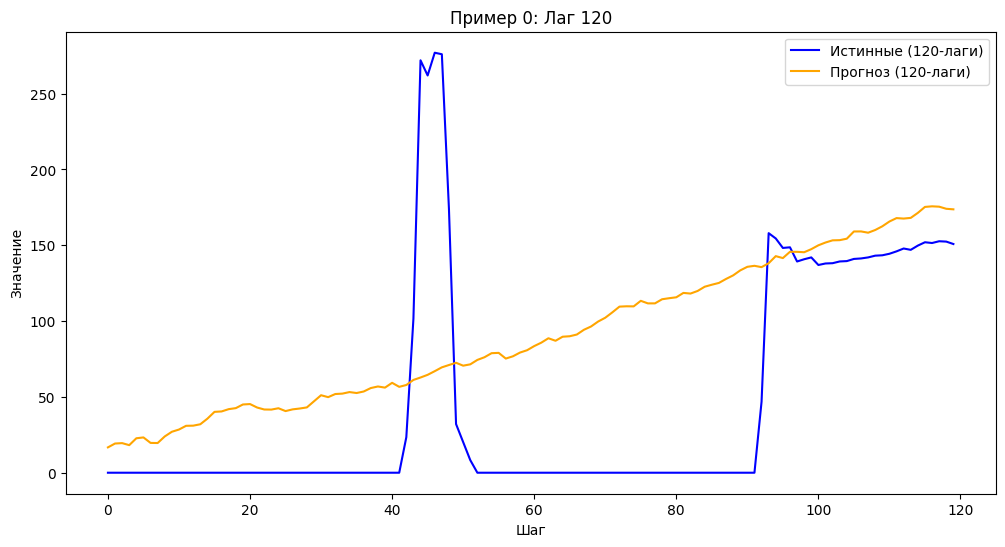

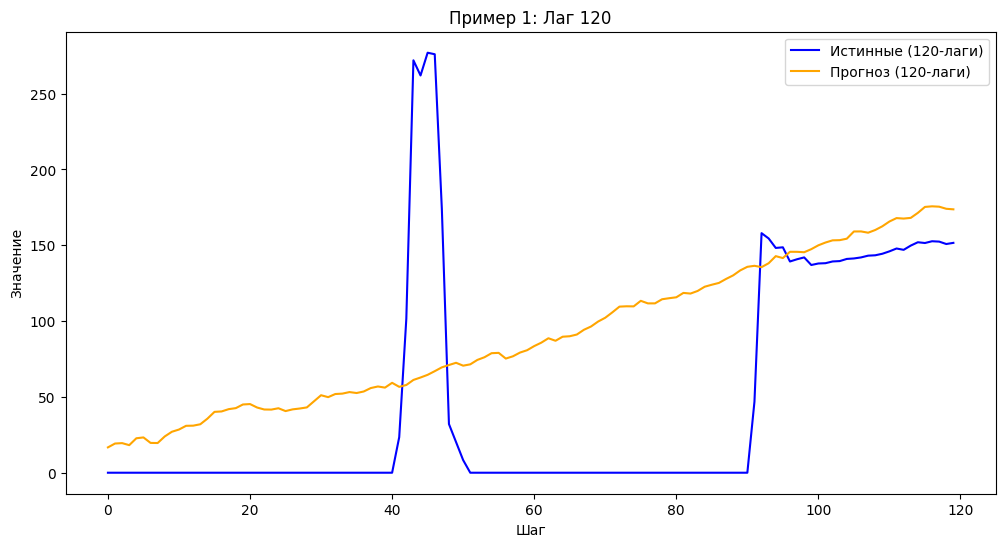

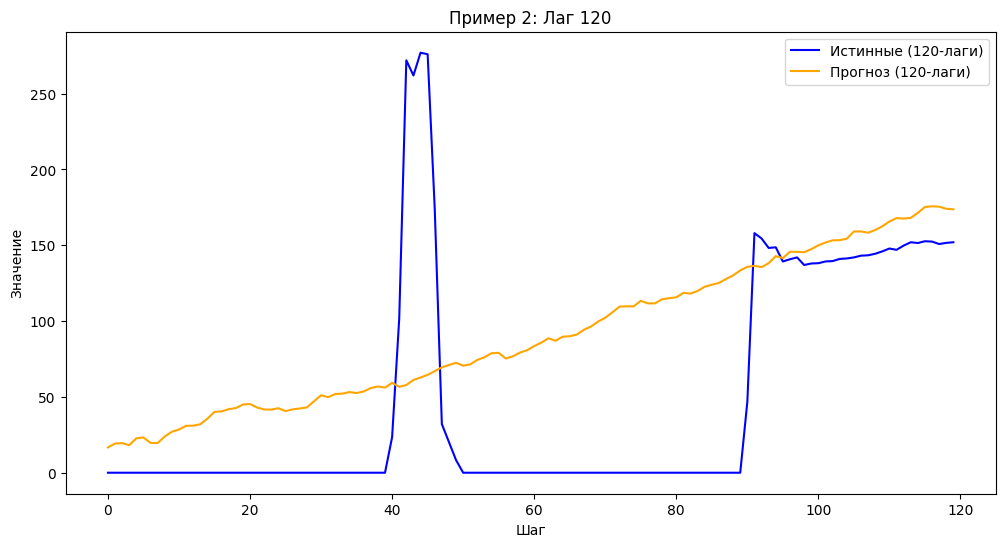

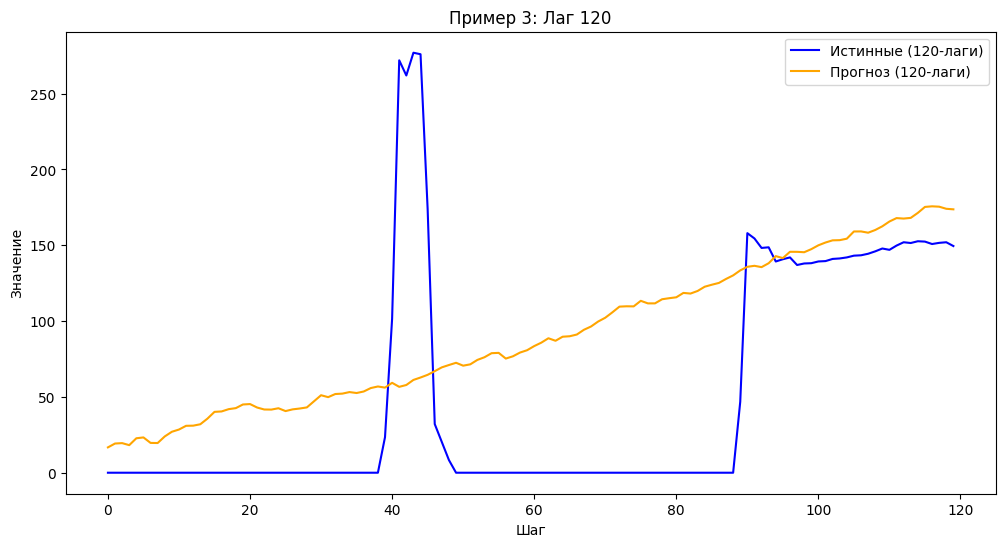

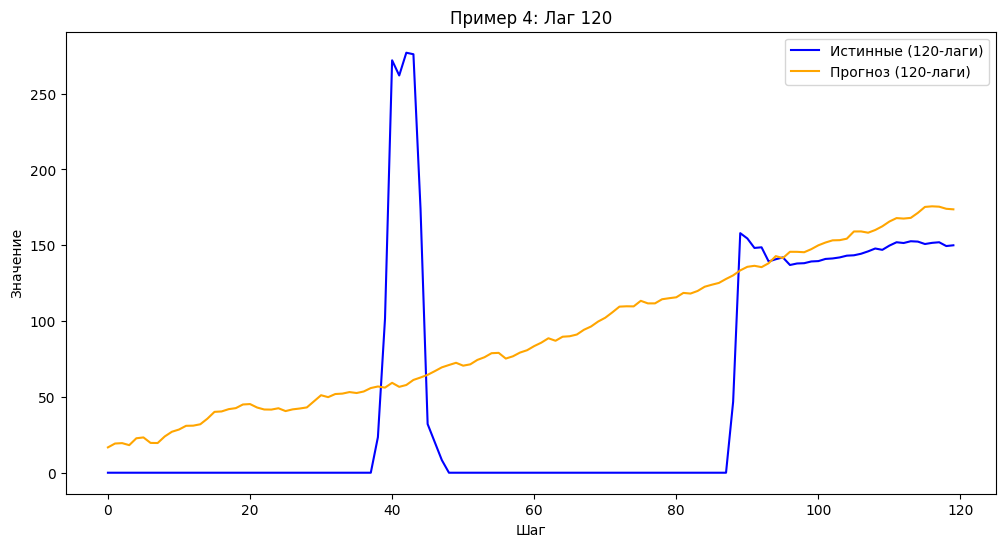

2196/2196 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step

Final evaluation shapes:
Y_val flattened: (8429400,)
Predicted values flattened: (8429400,)
Среднее абсолютное отклонение (MAE) для лагов 120: 109.5358



In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]
    print("\nShapes before training:")
    print("X_train:", X_train.shape)
    print("Y_train:", Y_train.shape)
    print("X_val:", X_val.shape)
    print("Y_val:", Y_val.shape)

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)
    for idx in range(min(5, len(predictions))):
        true_values = Y_val[idx].flatten()
        pred_values = predictions[idx].flatten()

        # Возвращаем к оригинальной шкале
        true_denorm = denormalize_data(true_values)
        pred_denorm = denormalize_data(pred_values)

        plt.figure(figsize=(12, 6))
        plt.plot(true_denorm, label=f'Истинные ({lag}-лаги)', color='blue')
        plt.plot(pred_denorm, label=f'Прогноз ({lag}-лаги)', color='orange')
        plt.xlabel('Шаг')
        plt.ylabel('Значение')
        plt.title(f'Пример {idx}: Лаг {lag}')
        plt.legend()
        plt.show()

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")